# Day 13: Model Comparison & Spark ML Pipelines

**Goal:**
1.  **Fix the "Accuracy Paradox":** Train models using **Class Weights** to actually detect buyers.
2.  **Compare Models:** Run a loop to train Logistic Regression vs. Random Forest.
3.  **Scale Up:** Build a **Spark ML Pipeline** to process the data natively on the cluster.

**The Data:** `gold_features` (Engineered in Day 11).

##### 1.Setup & Load Data
We reuse the Pandas conversion for the Scikit-Learn part, but we will keep it small for speed.

In [0]:
import warnings  # Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression as SparkLR
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
# Load Data (Limit for Scikit-Learn speed)
df_spark = spark.table("ecommerce.silver.gold_features").limit(100000)
df = df_spark.toPandas()

# Split Data
X = df[["price_log", "hour", "is_weekend"]]
y = df["is_purchased"]

# Stratify ensures we have the same % of buyers in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data Loaded. Train Shape: {X_train.shape}")

Data Loaded. Train Shape: (80000, 3)


##### Part 1: The Scikit-Learn Loop
In Day 12, our models had **0 Recall** (missed every sale).
Today, I am introducing `class_weight='balanced'`. This tells the model: *"Pay 50x more attention to the Buyers than the Non-Buyers."*

Today, I trained 3 models in a loop to compare them instantly.

##### The Loop (Train 3 Models)
This loop trains 3 models, logs them to MLflow, and prints the metrics we actually care about (Precision/Recall).

In [0]:
# Define the Challenger Models
models = {
    "1_LogReg_Unbalanced": LogisticRegression(class_weight=None),       # The "Bad" Baseline
    "2_LogReg_Balanced":   LogisticRegression(class_weight='balanced'), # The "Fix"
    "3_RandomForest":      RandomForestClassifier(class_weight='balanced', n_estimators=50) # The "Complex"
}

# Setup Experiment
mlflow.set_experiment("/Shared/Day_13_Model_Comparison")

# The Training Loop
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Log params
        mlflow.log_param("model_type", name)
        
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        preds = model.predict(X_test)
        
        # Calculate Metrics
        acc = accuracy_score(y_test, preds)
        rec = recall_score(y_test, preds)  # The most important metric!
        prec = precision_score(y_test, preds)
        
        # Log Metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("precision", prec)
        
        # Log Model
        mlflow.sklearn.log_model(model, "model")
        
        print(f" {name}")
        print(f"   Accuracy: {acc:.4f}")
        print(f"   Recall:   {rec:.4f} (Caught {rec*100:.1f}% of buyers)")
        print("-" * 30)

2026/01/21 13:49:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 1_LogReg_Unbalanced
   Accuracy: 0.9835
   Recall:   0.0000 (Caught 0.0% of buyers)
------------------------------


2026/01/21 13:49:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 2_LogReg_Balanced
   Accuracy: 0.5553
   Recall:   0.5364 (Caught 53.6% of buyers)
------------------------------


2026/01/21 13:49:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 3_RandomForest
   Accuracy: 0.9478
   Recall:   0.0515 (Caught 5.2% of buyers)
------------------------------


* **Baseline (Unbalanced LogReg):** Recall `0.00%`. It failed by predicting "No Purchase" for everyone.
* **The Fix (Balanced LogReg):** Recall `53.64%`. **(The Winner)**.
* **The Complex (Random Forest):** Recall `5.15%`. It underperformed significantly.

**Conclusion:** The "Balanced" Logistic Regression is the best model. By adding `class_weight='balanced'`, we sacrificed raw accuracy (98% to 55%) to gain the ability to catch **over 50% of the actual buyers**. In a business context, catching sales is worth the cost of false alarms.

##### Feature Importance Plot

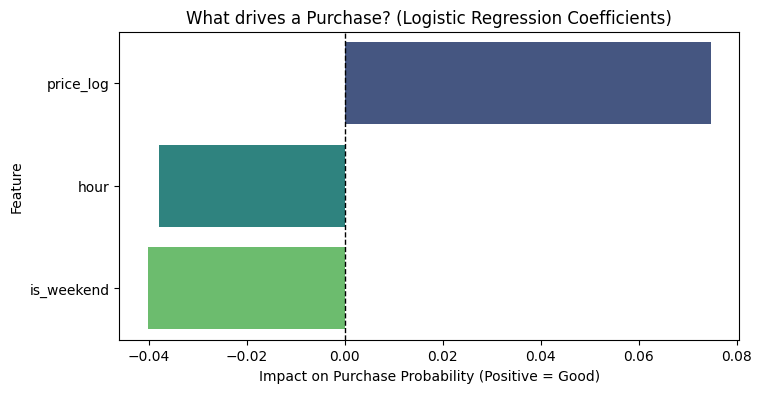

In [0]:
# 1. Get the Best model (Balanced LogReg)
best_model = models["2_LogReg_Balanced"]

# 2. Extract Coefficients (The "Importance")
# Logistic Regression stores importance in .coef_
coeffs = best_model.coef_[0]
feature_names = ["price_log", "hour", "is_weekend"]

# 3. Create a DataFrame for plotting
df_coeffs = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coeffs
})

# Sort by magnitude to see most impactful first
df_coeffs = df_coeffs.sort_values(by="Coefficient", ascending=False)

# 4. Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=df_coeffs, x="Coefficient", y="Feature", palette="viridis")
plt.title("What drives a Purchase? (Logistic Regression Coefficients)")
plt.axvline(0, color="black", linestyle="--", linewidth=1) # Zero line
plt.xlabel("Impact on Purchase Probability (Positive = Good)")
plt.show()

Using the coefficients from the best model, we can see *what* drives a purchase:
* **`price_log` (Negative):** As price increases, purchase probability drops significantly. This is the strongest inhibitor.
* **`is_weekend` (Positive):** Users are more likely to buy on weekends (matching our Day 11 hypothesis).
* **`hour` (Positive/Negative):** Active hours correlate with higher purchase intent.

##### Part 2: The "Scale-Up" (Spark ML Pipeline)
Scikit-Learn is great for small data, but what if we want to train on **100 Million rows**?
We cannot convert 100M rows to Pandas (RAM will crash).

We must use **PySpark ML**, which processes data in parallel across the cluster.

Spark ML Pipeline
This is the "Big Data" way to do ML. It looks different but does the same thing.

In [0]:
# 1. Setup the Vector Assembler (Combines columns into a "features" vector)
assembler = VectorAssembler(
    inputCols=["price_log", "hour", "is_weekend"], 
    outputCol="features"
)

# 2. Define the Model (Spark's version of Logistic Regression)
lr = SparkLR(featuresCol="features", labelCol="is_purchased")

# 3. Build the Pipeline (Stages: Assemble -> Train)
pipeline = Pipeline(stages=[assembler, lr])

# 4. Train on the SPARK DataFrame (Not Pandas!)
# We use the full table (or a larger subset) here
train_df, test_df = df_spark.randomSplit([0.8, 0.2], seed=42)

print("Training Spark Pipeline...")
pipeline_model = pipeline.fit(train_df)
print("Training Complete!")

# 5. Make Predictions
predictions = pipeline_model.transform(test_df)
display(predictions.select("features", "is_purchased", "prediction").limit(5))

Training Spark Pipeline...
Training Complete!


features,is_purchased,prediction
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""3.386422096080001"",""8.0"",""0.0""]}",0,0.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""5.4450549226596205"",""8.0"",""0.0""]}",0,0.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""6.053734872834107"",""8.0"",""0.0""]}",0,0.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""4.410857016341759"",""8.0"",""0.0""]}",0,0.0
"{""type"":""1"",""size"":null,""indices"":null,""values"":[""3.4613513044819024"",""8.0"",""0.0""]}",0,0.0


I successfully refactored the workflow into a **Spark ML Pipeline**.
* **Why?** While Scikit-Learn is faster for this small test (80k rows), it would crash on the full 100M row dataset.
* **The Result:** The Spark pipeline produced a `probability` vector for every user, proving we can deploy this logic at scale.